In [27]:
# manipulation des données
import numpy as np
import pandas as pd

# matplotlib et seaborn pour les représentations graphiques
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# sklearn preprocessing pour le traiter les variables catégorielles
from sklearn.preprocessing import LabelEncoder

# Gestion du système de fichiers
import os

# Suppression des alertes
import warnings
warnings.filterwarnings('ignore')

In [28]:
df = pd.read_csv("../Data/1.normalized_dataset_max.csv")

In [29]:
#import ast

#array_list = df['description_token'].values
#data_list = []
#for item in array_list:
#    data_list.append(ast.literal_eval(item))

#df['description_token'] = data_list
#df

In [30]:
df['cluster'] = 0
df.loc[df['product_category_tree'] == 'Home Furnishing', 'cluster'] = 0
df.loc[df['product_category_tree'] == 'Baby Care', 'cluster'] = 1
df.loc[df['product_category_tree'] == 'Watches', 'cluster'] = 2
df.loc[df['product_category_tree'] == 'Home Decor & Festive Needs', 'cluster'] = 3
df.loc[df['product_category_tree'] == 'Kitchen & Dining', 'cluster'] = 4
df.loc[df['product_category_tree'] == 'Beauty and Personal Care', 'cluster'] = 5
df.loc[df['product_category_tree'] == 'Computers', 'cluster'] = 6

In [31]:
l_cat = list(set(df['product_category_tree']))
print("catégories : ", l_cat)

catégories :  ['Baby Care', 'Watches', 'Home Decor & Festive Needs', 'Kitchen & Dining', 'Home Furnishing', 'Computers', 'Beauty and Personal Care']


In [32]:
y_cat_num = []

for i in range(len(df)):
    category = df.iloc[i]['product_category_tree']
    index_of_category = l_cat.index(category)
    transformed_value = 1 - index_of_category
    y_cat_num.append(transformed_value)

In [33]:
#from nltk.tokenize import word_tokenize

#df['words'] = df['words'].astype(str)
#for i in range(len(df['words'])):
#    tokenize_description = word_tokenize(df['words'][i])
#    df['description_token'][i] = tokenize_description

In [34]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'
os.environ["TFHUB_MODEL_LOAD_FORMAT"] = "UNCOMPRESSED"

In [35]:
import tensorflow as tf
import tensorflow_hub as hub
import shutil

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [36]:
import time

def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [37]:
batch_size = 10
sentences = df['words'].to_list()

In [38]:
features_USE = feature_USE_fct(sentences, batch_size)

In [39]:
from sklearn import manifold

tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(features_USE)

df_tsne = pd.DataFrame({"tsne_1" : X_tsne[:, 0], "tsne_2" : X_tsne[:, 1], "cluster" : df['cluster']})

In [40]:
from sklearn import cluster

X = df_tsne.drop('cluster', axis=1).values
kmeans = cluster.KMeans(n_clusters=7, n_init=100, random_state=42)
df_tsne['cluster_predict'] = kmeans.fit_predict(X)

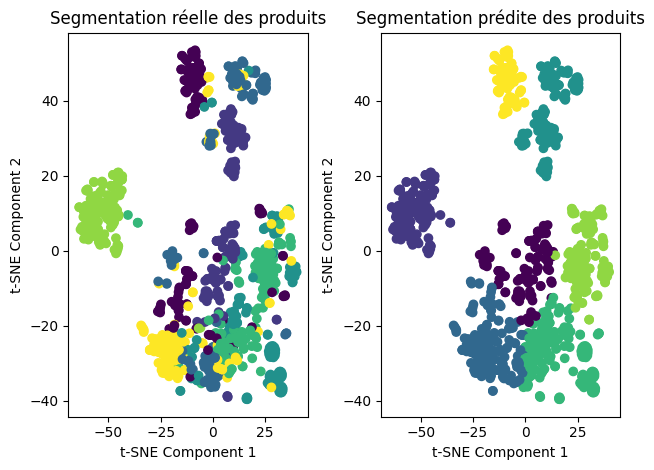

In [41]:
plt.subplot(1, 2, 1)
plt.scatter(df_tsne['tsne_1'], df_tsne['tsne_2'], c=y_cat_num, cmap='viridis')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Segmentation réelle des produits')

plt.subplot(1, 2, 2)
plt.scatter(df_tsne['tsne_1'], df_tsne['tsne_2'], c=df_tsne['cluster_predict'], cmap='viridis')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Segmentation prédite des produits')

plt.tight_layout()
plt.show()

In [42]:
from sklearn import metrics
ARI = np.round(metrics.adjusted_rand_score(y_cat_num, kmeans.labels_),4)
ARI

0.3828